In [9]:
import tensorflow as tf
import numpy as np
import os

### 1.获取图片路径与标签

In [10]:
def get_files(file_dir):
    #file_dir为文件夹路径
    #返回乱序后的图片和标签
    
    #cats保存猫图片的路径，label_cats保存标签，均为list类型
    #dogs同理
    cats = []
    label_cats = []
    dogs = []
    label_dogs =[]
    
    for file in os.listdir(file_dir):
        name = file.split('.')
        if name[0] == 'cat':
            cats.append(file_dir+file)
            label_cats.append(0)
        else:
            dogs.append(file_dir+file)
            label_dogs.append(1)
    print('There are {} cats and there are {} dogs'.format(len(cats), len(dogs)))
    
    #打乱顺序
    image_list = np.hstack((cats, dogs))
    label_list = np.hstack((label_cats, label_dogs))
    temp = np.array([image_list, label_list])
    temp = temp.transpose()
    np.random.shuffle(temp)
    
    image_list = list(temp[:, 0])
    label_list = list(temp[:,1])
    label_list = [int(i) for i in label_list]
    
    return image_list, label_list

### 2.将图片和标签分batch

In [19]:
def get_batch(image, label, image_W, image_H, batch_size, capacity):
    #image和label 分别为图片和标签的list，由上一步函数得到
    #image_W和image_H为处理后的图片大小
    #batch_size每个batch有多少张图片
    #capacity队列容量
    #返回图片和标签的batch
    
    image = tf.cast(image, tf.string)
    label = tf.cast(label, tf.int32)
    
    #生成队列
    input_queue = tf.train.slice_input_producer([image, label])
    image_contents = tf.read_file(input_queue[0])
    image = tf.image.decode_jpeg(image_contents, channels=3)
    label = input_queue[1]
    
    #统一图片大小
    image = tf.image.resize_images(image, [image_W, image_H], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32)
    
    image_batch, label_batch = tf.train.batch([image, label],
                                             batch_size=batch_size,
                                             num_threads=64,    #64线程
                                             capacity=capacity)
    n_classes = 2
    label_batch = tf.one_hot(label_batch, depth=n_classes)
    label_batch = tf.reshape(label_batch, [batch_size, n_classes])
    return image_batch, label_batch

### 3.测试

There are 12500 cats and there are 12500 dogs
label: [[1. 0.]
 [0. 1.]]


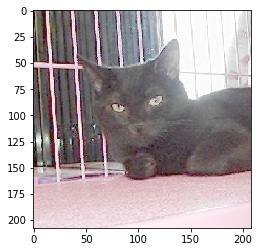

label: [[1. 0.]
 [0. 1.]]


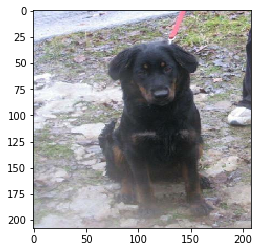

In [18]:
if __name__ == '__main__':
    import matplotlib.pyplot as plt

    BATCH_SIZE = 2
    CAPACITY = 256
    IMG_W = 208
    IMG_H = 208

    train_dir = "./data/train/"
    image_list, label_list = get_files(train_dir)
    image_batch, label_batch = get_batch(image_list, label_list, IMG_W, IMG_H, BATCH_SIZE, CAPACITY)

    with tf.Session() as sess:
        i = 0
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        try:
            while not coord.should_stop() and i < 1:
                img, label = sess.run([image_batch, label_batch])
                #图片转为float32了, 显示会出问题，所以要除以255， 否则图片颜色很奇怪
                #但是不除没有什么影响
                img /= 255

                for j in np.arange(BATCH_SIZE):
                    print("label: {}".format(label[j]))
                    plt.imshow(img[j, :, :, :])
                    plt.show()
                i += 1
        except tf.errors.OutOfRangeError:
            print("done!")
        finally:
            coord.request_stop()
        coord.join(threads)